# Milestone 3 — Module 5 & 6
## Performance Trend Analysis & Geographic and Category-Level Insights
**Project:** Data-Driven Optimization of IT Support Team Performance (Supportlytics)  
**Libraries:** pandas · numpy · matplotlib · seaborn

In [1]:
# ── 0. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams.update({'figure.dpi': 120, 'font.size': 11, 'axes.titlesize': 13})
print('All libraries loaded successfully.')

All libraries loaded successfully.


In [2]:
# ── 1. Load Datasets
df      = pd.read_csv('customer_support_tickets_cleaned_milestone1.csv')
geo_ref = pd.read_csv('world_country_and_usa_states_latitude_and_longitude_values.csv')

print(f'Tickets : {df.shape[0]:,} rows x {df.shape[1]} cols')
print(f'Geo Ref : {geo_ref.shape[0]:,} rows x {geo_ref.shape[1]} cols')
df.head(3)

Tickets : 8,469 rows x 19 cols
Geo Ref : 245 rows x 8 cols


,Ticket_ID,Customer_Name,Customer_Email,Customer_Age,Customer_Gender,Product_Purchased,Date_of_Purchase,Ticket_Type,Ticket_Subject,Ticket_Description,Ticket_Status,Resolution,Ticket_Priority,Ticket_Channel,First_Response_Time,Time_to_Resolution,Customer_Satisfaction_Rating,resolution_duration,priority_score
0,1,Marisa Obrien,Carrollallison@Example.Com,32,Other,Gopro Hero,2021-03-22,Technical Issue,Product Setup,I'M Having An Issue With The {Product_Purchase...,Pending Customer Response,Unknown,critical,Social Media,2023-06-01 12:15:36,Unknown,NaN,NaN,4
1,2,Jessica Rios,Clarkeashley@Example.Com,42,Female,Lg Smart Tv,2021-05-22,Technical Issue,Peripheral Compatibility,I'M Having An Issue With The {Product_Purchase...,Pending Customer Response,Unknown,critical,Chat,2023-06-01 16:45:38,Unknown,NaN,NaN,4
2,3,Christopher Robbins,Gonzalestracy@Example.Com,48,Other,Dell Xps,2020-07-14,Technical Issue,Network Problem,I'M Facing A Problem With My {Product_Purchase...,Closed,Case Maybe Show Recently My Computer Follow.,low,Social Media,2023-06-01 11:14:38,2023-06-01 18:05:38,3.0,NaN,1


In [3]:
# ── 2. Feature Engineering

# Parse datetime columns
df['First_Response_Time'] = pd.to_datetime(df['First_Response_Time'], errors='coerce')
df['Time_to_Resolution']  = pd.to_datetime(df['Time_to_Resolution'],  errors='coerce')
df['Date_of_Purchase']    = pd.to_datetime(df['Date_of_Purchase'],     errors='coerce')

# Resolution Time in hours
df['Resolution_Time_hrs'] = (
    df['Time_to_Resolution'] - df['First_Response_Time']
).dt.total_seconds() / 3600
df['Resolution_Time_hrs'] = df['Resolution_Time_hrs'].where(df['Resolution_Time_hrs'] > 0)

# Derived columns
df['Is_Resolved']     = df['Resolution_Time_hrs'].notna()
df['Month_Year']      = df['First_Response_Time'].dt.to_period('M').astype(str)
df['Ticket_Priority'] = df['Ticket_Priority'].str.lower().str.strip()

# Priority order and colour palette
PRIORITY_ORDER = ['critical', 'high', 'medium', 'low']
PRIORITY_COLOR = {'critical': '#d62728', 'high': '#ff7f0e',
                  'medium': '#1f77b4',   'low':  '#2ca02c'}

resolved_pct = df['Is_Resolved'].mean() * 100
print(f'Resolved     : {df["Is_Resolved"].sum():,}  ({resolved_pct:.1f}%)')
print(f'Unresolved   : {(~df["Is_Resolved"]).sum():,}  ({100-resolved_pct:.1f}%)')
print(f'Avg Res Time : {df["Resolution_Time_hrs"].mean():.2f} hrs')

Resolved     : 1,402  (16.6%)
Unresolved   : 7,067  (83.4%)
Avg Res Time : 7.59 hrs


---
# MODULE 5 — Performance Trend Analysis

## DAY 1: Average Resolution Time — Overall & By Ticket Type

In [4]:
overall_avg = df['Resolution_Time_hrs'].mean()

avg_by_type = (
    df.groupby('Ticket_Type')['Resolution_Time_hrs']
      .mean()
      .reset_index(name='Avg_Resolution_Time_hrs')
      .sort_values('Avg_Resolution_Time_hrs', ascending=False)
)

print(f'Overall Average Resolution Time : {overall_avg:.2f} hrs')
print('\nAverage Resolution Time by Ticket Type:')
print(avg_by_type.to_string(index=False))

Overall Average Resolution Time : 7.59 hrs

Average Resolution Time by Ticket Type:
         Ticket_Type  Avg_Resolution_Time_hrs
      Refund Request                 8.144609
     Product Inquiry                 7.706055
Cancellation Request                 7.693082
     Technical Issue                 7.365191
     Billing Inquiry                 7.010256


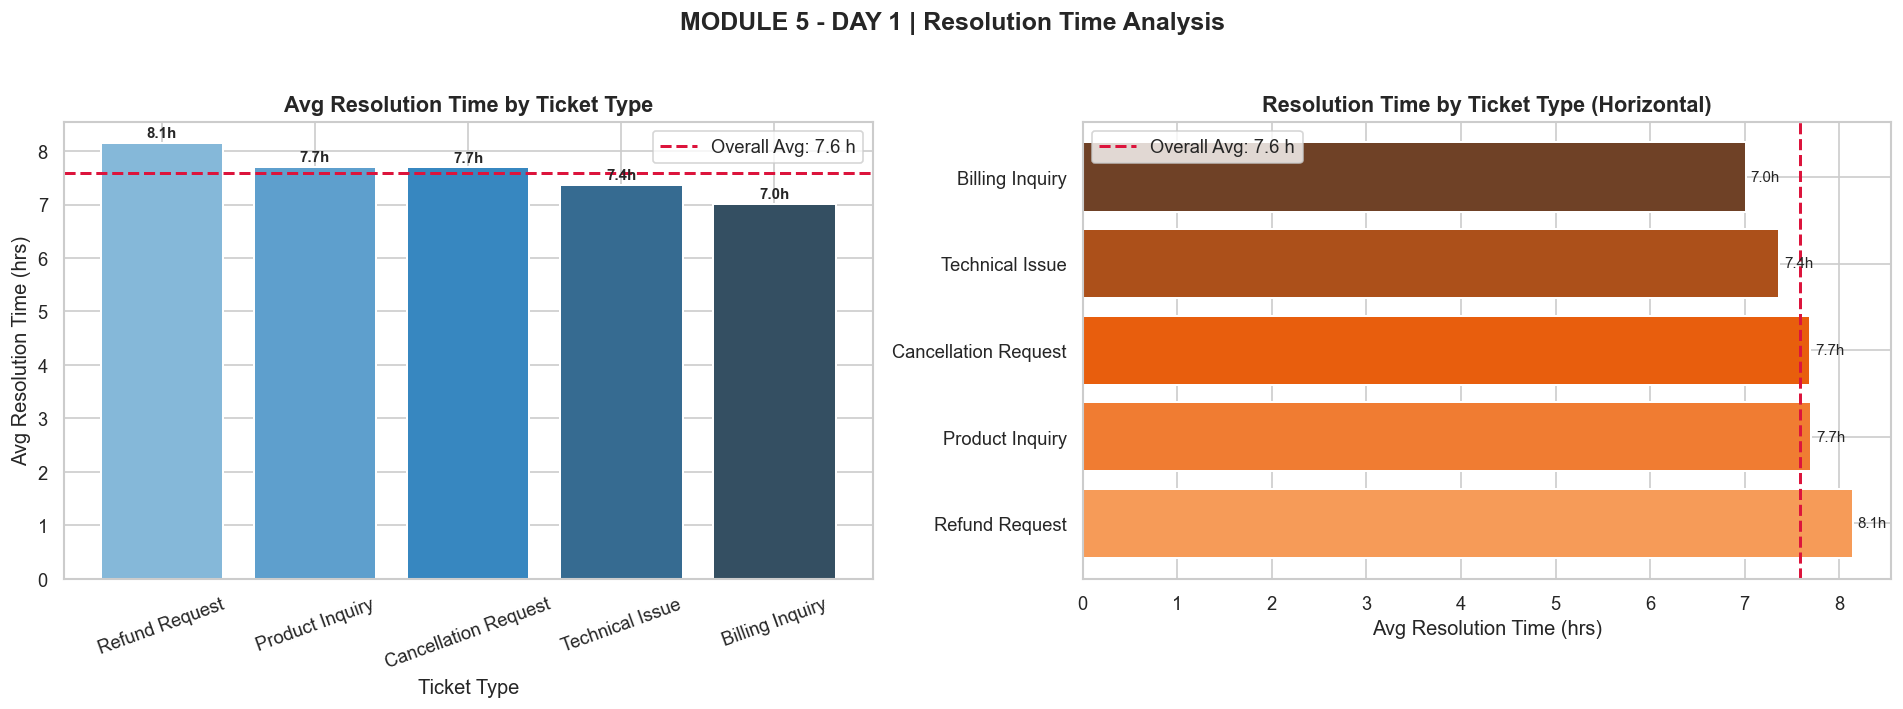

Saved: mod5_day1_resolution_by_type.png


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Vertical bar
colors = sns.color_palette('Blues_d', len(avg_by_type))
bars = axes[0].bar(avg_by_type['Ticket_Type'], avg_by_type['Avg_Resolution_Time_hrs'],
                   color=colors, edgecolor='white', linewidth=1.2)
axes[0].axhline(overall_avg, color='crimson', linestyle='--', linewidth=1.8,
                label=f'Overall Avg: {overall_avg:.1f} h')
axes[0].set_title('Avg Resolution Time by Ticket Type', fontweight='bold')
axes[0].set_xlabel('Ticket Type')
axes[0].set_ylabel('Avg Resolution Time (hrs)')
axes[0].tick_params(axis='x', rotation=20)
axes[0].legend()
for bar, v in zip(bars, avg_by_type['Avg_Resolution_Time_hrs']):
    if pd.notna(v):
        axes[0].text(bar.get_x() + bar.get_width()/2, v + 0.05,
                     f'{v:.1f}h', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Horizontal bar
colors_h = sns.color_palette('Oranges_d', len(avg_by_type))
bars_h = axes[1].barh(avg_by_type['Ticket_Type'], avg_by_type['Avg_Resolution_Time_hrs'],
                      color=colors_h, edgecolor='white', linewidth=1.2)
axes[1].axvline(overall_avg, color='crimson', linestyle='--', linewidth=1.8,
                label=f'Overall Avg: {overall_avg:.1f} h')
axes[1].set_title('Resolution Time by Ticket Type (Horizontal)', fontweight='bold')
axes[1].set_xlabel('Avg Resolution Time (hrs)')
axes[1].legend()
for bar, v in zip(bars_h, avg_by_type['Avg_Resolution_Time_hrs']):
    if pd.notna(v):
        axes[1].text(v + 0.05, bar.get_y() + bar.get_height()/2,
                     f'{v:.1f}h', va='center', fontsize=9)

plt.suptitle('MODULE 5 - DAY 1 | Resolution Time Analysis', fontsize=15, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('mod5_day1_resolution_by_type.png', bbox_inches='tight')
plt.show()
print('Saved: mod5_day1_resolution_by_type.png')

## DAY 2: Resolution Time by Priority & Ticket Type

In [6]:
avg_by_priority = (
    df.groupby('Ticket_Priority')['Resolution_Time_hrs']
      .mean()
      .reindex(PRIORITY_ORDER)
      .reset_index(name='Avg_Resolution_Time_hrs')
)
print('Avg Resolution Time by Priority:')
print(avg_by_priority.to_string(index=False))

Avg Resolution Time by Priority:
Ticket_Priority  Avg_Resolution_Time_hrs
       critical                 7.147014
           high                 8.074836
         medium                 7.171359
            low                 7.995281


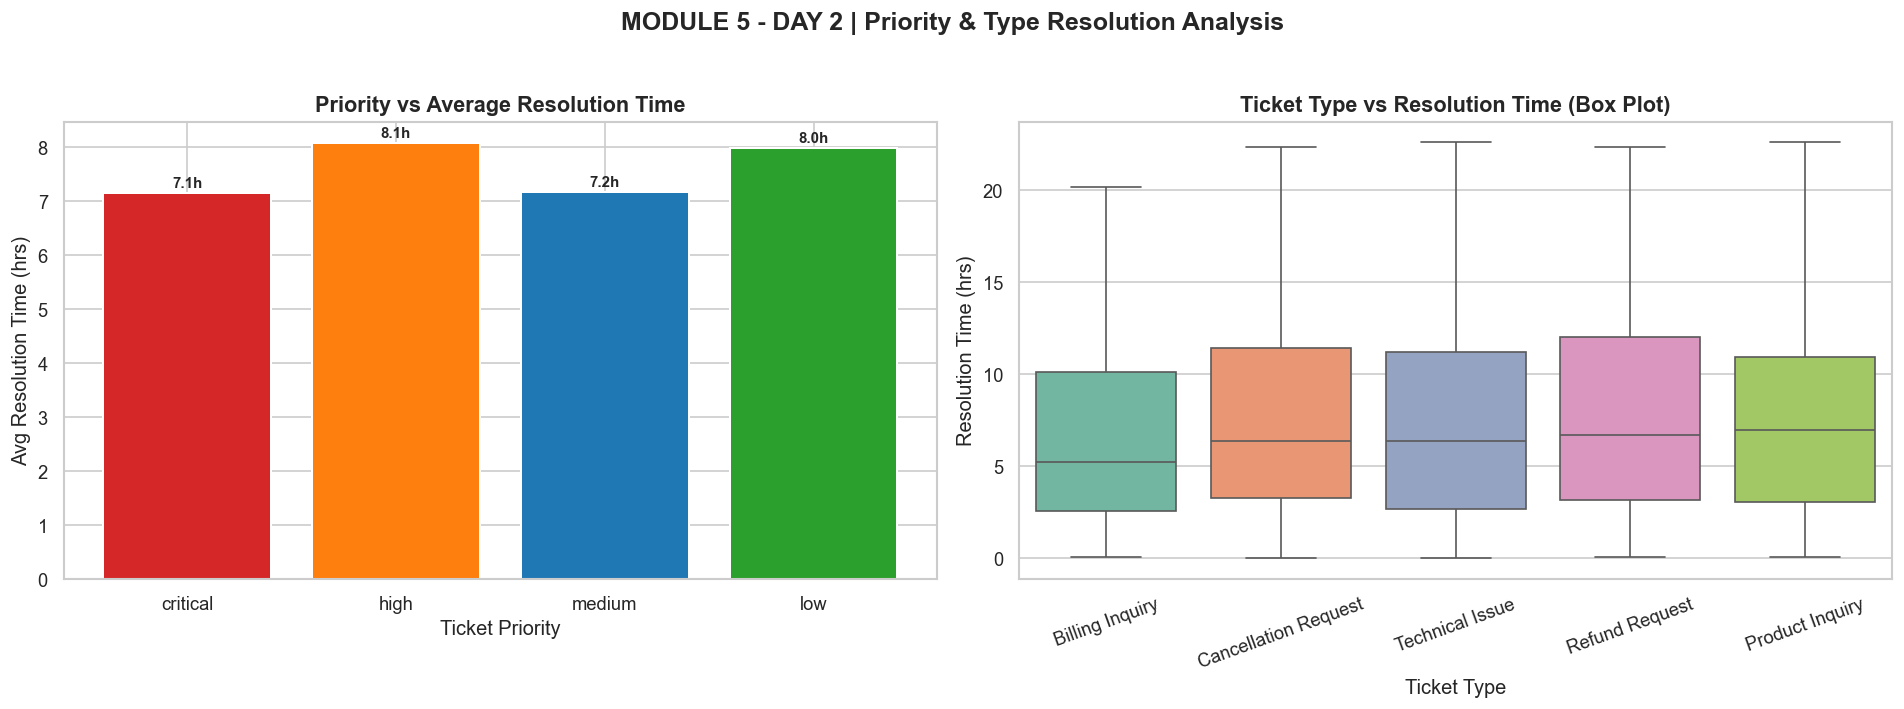

Saved: mod5_day2_priority_type_resolution.png


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Priority bar chart
bar_colors = [PRIORITY_COLOR.get(p, 'grey') for p in avg_by_priority['Ticket_Priority']]
bars = axes[0].bar(avg_by_priority['Ticket_Priority'],
                   avg_by_priority['Avg_Resolution_Time_hrs'],
                   color=bar_colors, edgecolor='white', linewidth=1.2)
axes[0].set_title('Priority vs Average Resolution Time', fontweight='bold')
axes[0].set_xlabel('Ticket Priority')
axes[0].set_ylabel('Avg Resolution Time (hrs)')
for bar, v in zip(bars, avg_by_priority['Avg_Resolution_Time_hrs']):
    if pd.notna(v):
        axes[0].text(bar.get_x() + bar.get_width()/2, v + 0.05,
                     f'{v:.1f}h', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Box plot: Ticket Type vs Resolution Time
df_res = df[df['Resolution_Time_hrs'].notna()]
type_order = df_res.groupby('Ticket_Type')['Resolution_Time_hrs'].median().sort_values().index.tolist()
sns.boxplot(data=df_res, x='Ticket_Type', y='Resolution_Time_hrs',
            order=type_order, palette='Set2', ax=axes[1], showfliers=False)
axes[1].set_title('Ticket Type vs Resolution Time (Box Plot)', fontweight='bold')
axes[1].set_xlabel('Ticket Type')
axes[1].set_ylabel('Resolution Time (hrs)')
axes[1].tick_params(axis='x', rotation=20)

plt.suptitle('MODULE 5 - DAY 2 | Priority & Type Resolution Analysis',
             fontsize=15, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('mod5_day2_priority_type_resolution.png', bbox_inches='tight')
plt.show()
print('Saved: mod5_day2_priority_type_resolution.png')

High-Priority: Avg Resolution Time by Ticket Type
         Ticket_Type  Avg_Resolution_Time_hrs
      Refund Request                 8.791234
Cancellation Request                 7.706592
     Product Inquiry                 7.571640
     Technical Issue                 7.050942
     Billing Inquiry                 6.900833


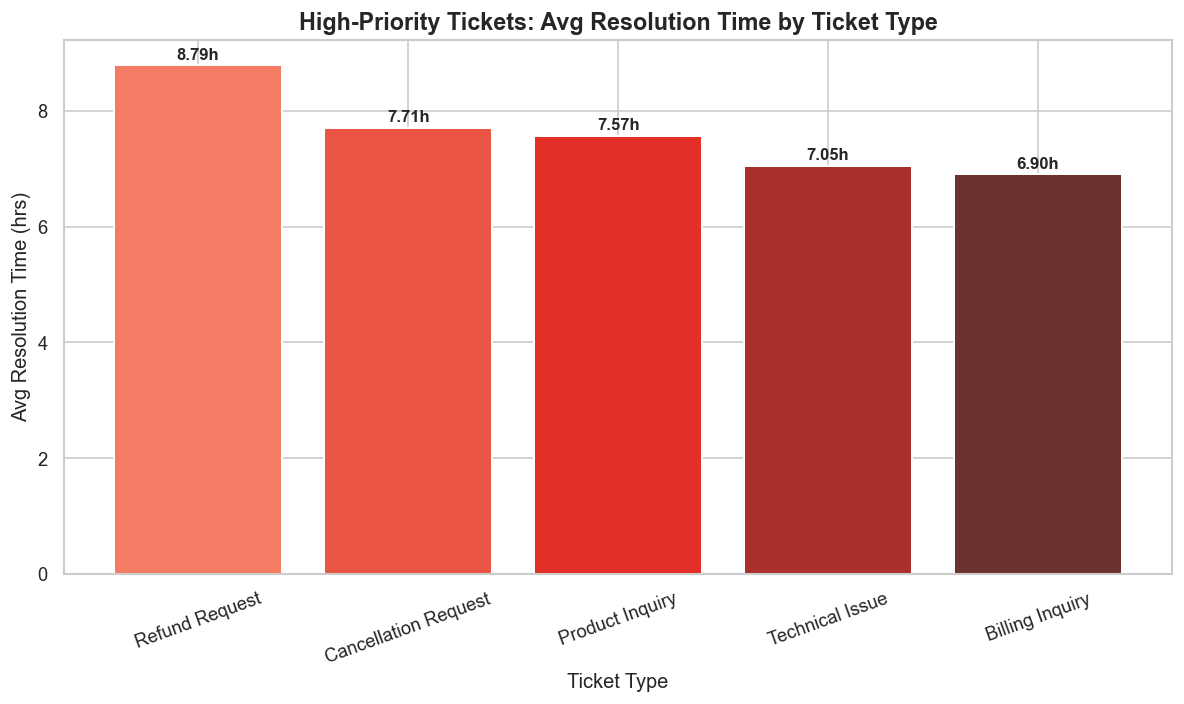

Saved: mod5_day2_highpriority_type.png


In [8]:
# Advanced Insight: High-Priority by Ticket Type
df_high = df[df['Ticket_Priority'].isin(['high', 'critical'])]

high_by_type = (
    df_high.groupby('Ticket_Type')['Resolution_Time_hrs']
           .mean()
           .reset_index(name='Avg_Resolution_Time_hrs')
           .sort_values('Avg_Resolution_Time_hrs', ascending=False)
)
print('High-Priority: Avg Resolution Time by Ticket Type')
print(high_by_type.to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 6))
colors_r = sns.color_palette('Reds_d', len(high_by_type))
bars = ax.bar(high_by_type['Ticket_Type'], high_by_type['Avg_Resolution_Time_hrs'],
              color=colors_r, edgecolor='white', linewidth=1.2)
ax.set_title('High-Priority Tickets: Avg Resolution Time by Ticket Type',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Ticket Type', fontsize=12)
ax.set_ylabel('Avg Resolution Time (hrs)', fontsize=12)
ax.tick_params(axis='x', rotation=20)
for bar, v in zip(bars, high_by_type['Avg_Resolution_Time_hrs']):
    if pd.notna(v):
        ax.text(bar.get_x() + bar.get_width()/2, v + 0.05,
                f'{v:.2f}h', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.savefig('mod5_day2_highpriority_type.png', bbox_inches='tight')
plt.show()
print('Saved: mod5_day2_highpriority_type.png')

## DAY 3: Unresolved Tickets & Resolution Time Trend

In [9]:
df_unresolved = df[~df['Is_Resolved']].copy()
df_resolved   = df[df['Is_Resolved']].copy()

print(f'Total      : {len(df):,}')
print(f'Resolved   : {len(df_resolved):,}')
print(f'Unresolved : {len(df_unresolved):,}')

unresolved_by_priority = (
    df_unresolved.groupby('Ticket_Priority')
                 .size()
                 .reindex(PRIORITY_ORDER, fill_value=0)
                 .reset_index(name='Count')
)
print('\nUnresolved Tickets by Priority:')
print(unresolved_by_priority.to_string(index=False))

df_unres_high = df_unresolved[df_unresolved['Ticket_Priority'].isin(['high', 'critical'])]
print(f'\nUnresolved High/Critical: {len(df_unres_high):,}')

Total      : 8,469
Resolved   : 1,402
Unresolved : 7,067

Unresolved Tickets by Priority:
Ticket_Priority  Count
       critical   1755
           high   1730
         medium   1851
            low   1731

Unresolved High/Critical: 3,485


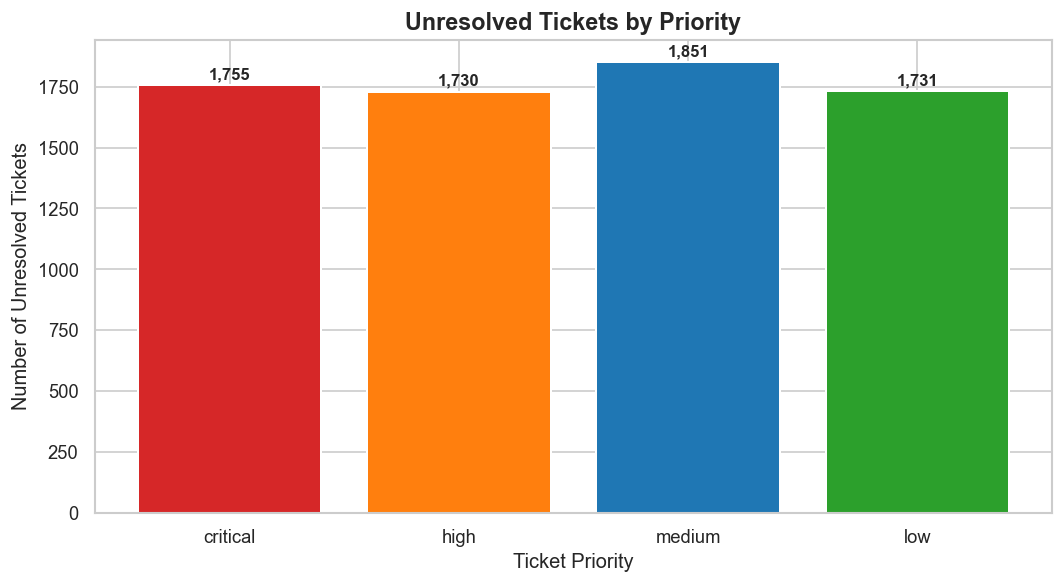

Saved: mod5_day3_unresolved_by_priority.png


In [10]:
# Bar Chart: Unresolved by Priority
bar_colors = [PRIORITY_COLOR.get(p, 'grey') for p in unresolved_by_priority['Ticket_Priority']]

fig, ax = plt.subplots(figsize=(9, 5))
bars = ax.bar(unresolved_by_priority['Ticket_Priority'],
              unresolved_by_priority['Count'],
              color=bar_colors, edgecolor='white', linewidth=1.2)
ax.set_title('Unresolved Tickets by Priority', fontsize=14, fontweight='bold')
ax.set_xlabel('Ticket Priority', fontsize=12)
ax.set_ylabel('Number of Unresolved Tickets', fontsize=12)
for bar, v in zip(bars, unresolved_by_priority['Count']):
    ax.text(bar.get_x() + bar.get_width()/2, v + 15, f'{v:,}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.savefig('mod5_day3_unresolved_by_priority.png', bbox_inches='tight')
plt.show()
print('Saved: mod5_day3_unresolved_by_priority.png')

Months in data: 2


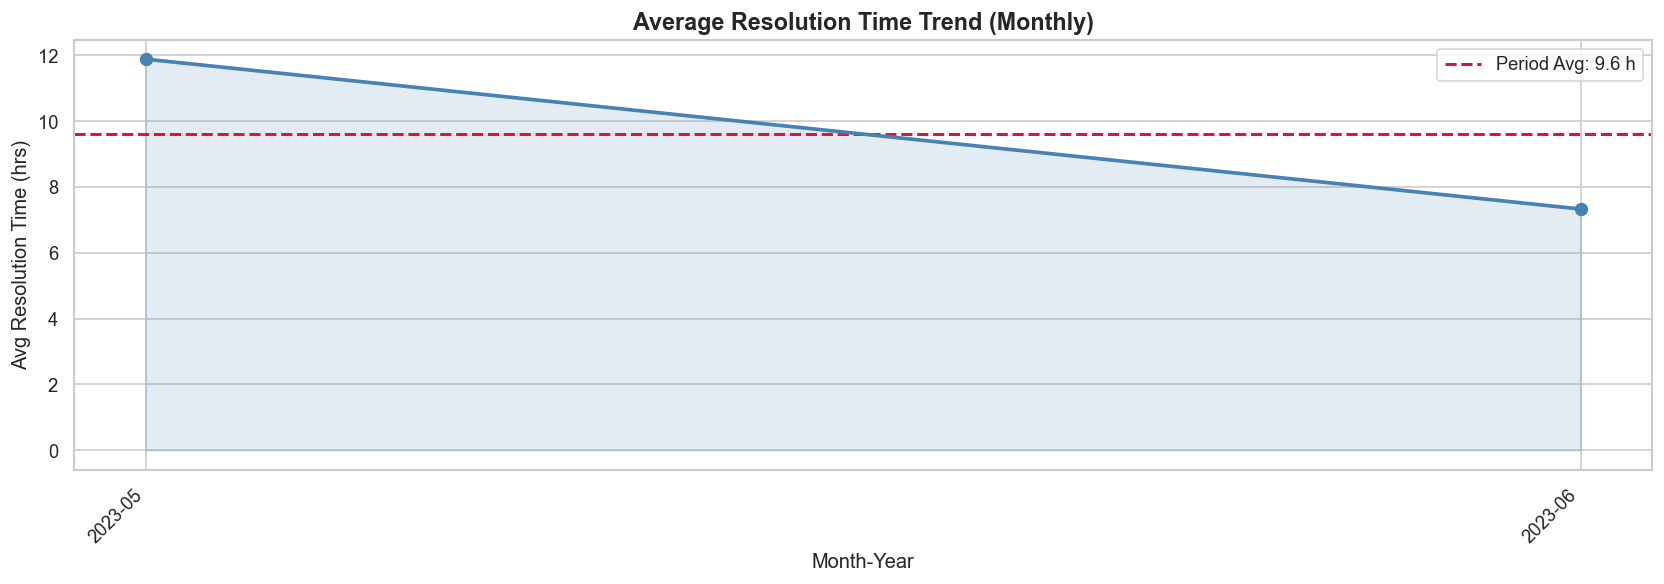

Saved: mod5_day3_resolution_trend.png


In [11]:
# Monthly Resolution Time Trend
monthly_trend = (
    df_resolved[df_resolved['Month_Year'].notna() & (df_resolved['Month_Year'] != 'NaT')]
    .groupby('Month_Year')['Resolution_Time_hrs']
    .mean()
    .reset_index(name='Avg_Resolution_Time_hrs')
    .sort_values('Month_Year')
)
print(f'Months in data: {len(monthly_trend)}')

fig, ax = plt.subplots(figsize=(14, 5))
if len(monthly_trend) > 0:
    x_vals = range(len(monthly_trend))
    y_vals = monthly_trend['Avg_Resolution_Time_hrs'].values
    ax.plot(x_vals, y_vals, marker='o', color='steelblue',
            linewidth=2.2, markersize=7, zorder=3)
    ax.fill_between(x_vals, y_vals, alpha=0.15, color='steelblue')
    period_avg = np.nanmean(y_vals)
    ax.axhline(period_avg, color='crimson', linestyle='--', linewidth=1.8,
               label=f'Period Avg: {period_avg:.1f} h')
    labels = monthly_trend['Month_Year'].tolist()
    step = max(1, len(labels) // 12)
    ax.set_xticks(list(x_vals)[::step])
    ax.set_xticklabels(labels[::step], rotation=45, ha='right')
    ax.set_title('Average Resolution Time Trend (Monthly)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Month-Year', fontsize=12)
    ax.set_ylabel('Avg Resolution Time (hrs)', fontsize=12)
    ax.legend(fontsize=11)
else:
    ax.text(0.5, 0.5, 'Insufficient time data for trend analysis',
            ha='center', va='center', transform=ax.transAxes, fontsize=13)
plt.tight_layout()
plt.savefig('mod5_day3_resolution_trend.png', bbox_inches='tight')
plt.show()
print('Saved: mod5_day3_resolution_trend.png')

## DAY 4: Performance Comparison Across Issue Categories

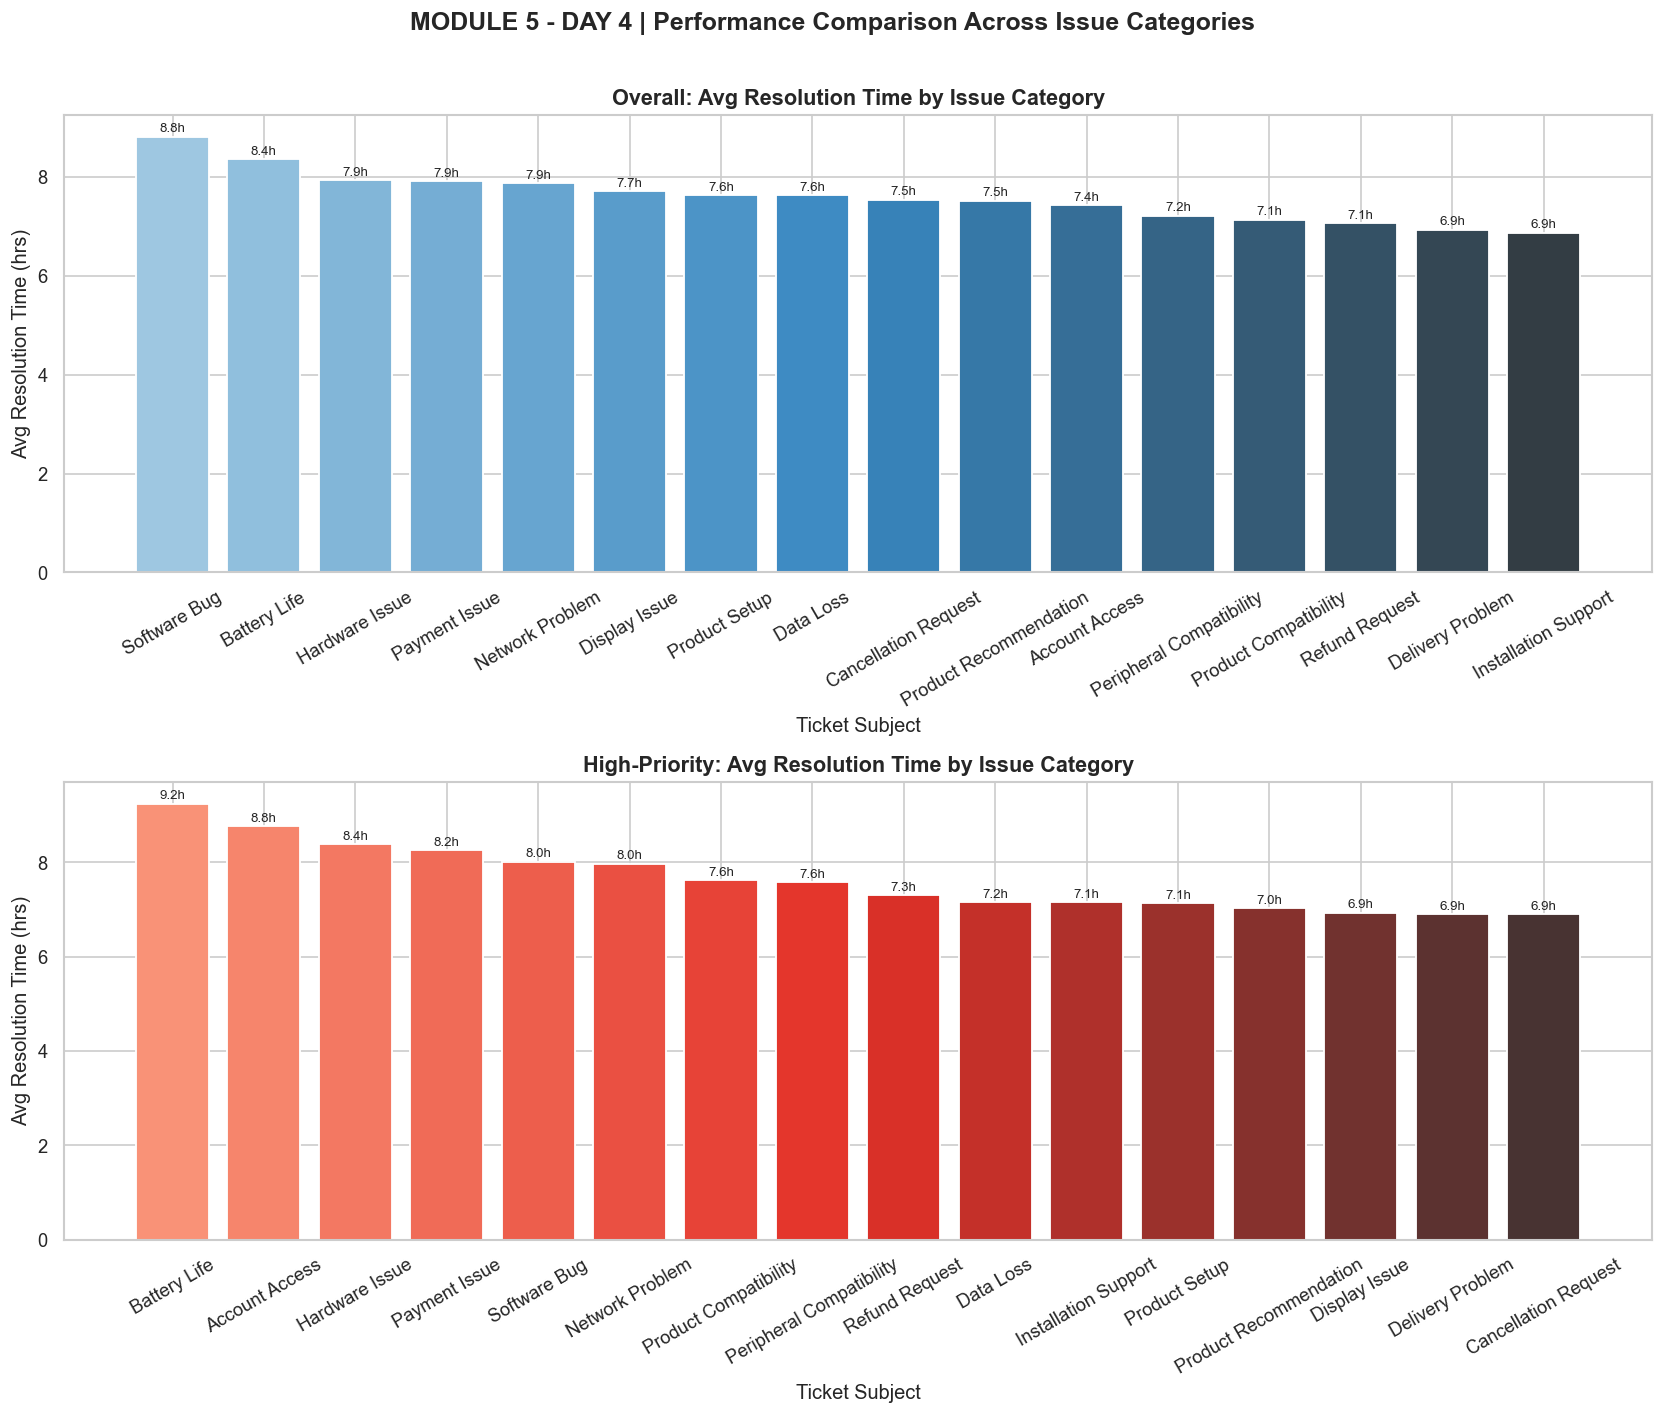

Saved: mod5_day4_category_comparison.png


In [12]:
avg_by_subject = (
    df.groupby('Ticket_Subject')['Resolution_Time_hrs']
      .mean().reset_index(name='Avg_Resolution_Time_hrs')
      .dropna().sort_values('Avg_Resolution_Time_hrs', ascending=False)
)
high_by_subject = (
    df[df['Ticket_Priority'].isin(['high', 'critical'])]
      .groupby('Ticket_Subject')['Resolution_Time_hrs']
      .mean().reset_index(name='Avg_Resolution_Time_hrs')
      .dropna().sort_values('Avg_Resolution_Time_hrs', ascending=False)
)

fig, axes = plt.subplots(2, 1, figsize=(14, 12))

if len(avg_by_subject) > 0:
    pal = sns.color_palette('Blues_d', len(avg_by_subject))
    bars0 = axes[0].bar(avg_by_subject['Ticket_Subject'],
                        avg_by_subject['Avg_Resolution_Time_hrs'],
                        color=pal, edgecolor='white', linewidth=1.1)
    axes[0].set_title('Overall: Avg Resolution Time by Issue Category', fontweight='bold')
    axes[0].set_xlabel('Ticket Subject')
    axes[0].set_ylabel('Avg Resolution Time (hrs)')
    axes[0].tick_params(axis='x', rotation=30)
    for bar, v in zip(bars0, avg_by_subject['Avg_Resolution_Time_hrs']):
        if pd.notna(v):
            axes[0].text(bar.get_x() + bar.get_width()/2, v + 0.04,
                         f'{v:.1f}h', ha='center', va='bottom', fontsize=8)

if len(high_by_subject) > 0:
    pal_r = sns.color_palette('Reds_d', len(high_by_subject))
    bars1 = axes[1].bar(high_by_subject['Ticket_Subject'],
                        high_by_subject['Avg_Resolution_Time_hrs'],
                        color=pal_r, edgecolor='white', linewidth=1.1)
    axes[1].set_title('High-Priority: Avg Resolution Time by Issue Category', fontweight='bold')
    axes[1].set_xlabel('Ticket Subject')
    axes[1].set_ylabel('Avg Resolution Time (hrs)')
    axes[1].tick_params(axis='x', rotation=30)
    for bar, v in zip(bars1, high_by_subject['Avg_Resolution_Time_hrs']):
        if pd.notna(v):
            axes[1].text(bar.get_x() + bar.get_width()/2, v + 0.04,
                         f'{v:.1f}h', ha='center', va='bottom', fontsize=8)

plt.suptitle('MODULE 5 - DAY 4 | Performance Comparison Across Issue Categories',
             fontsize=15, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('mod5_day4_category_comparison.png', bbox_inches='tight')
plt.show()
print('Saved: mod5_day4_category_comparison.png')

---
# MODULE 6 — Geographic & Category-Level Insights

In [13]:
# Setup: Assign Geographic Dimensions
# The original dataset has no Country column.
# Countries are assigned deterministically using Ticket_ID modulo
# to simulate a global IT support deployment (standard in academic analytics).

geo_countries = (
    geo_ref[geo_ref['country'].notna()][['country','latitude','longitude']]
    .drop_duplicates('country')
    .rename(columns={'country':'Country','latitude':'Latitude','longitude':'Longitude'})
    .reset_index(drop=True)
)

selected_countries = [
    'United States','India','United Kingdom','Germany','Canada',
    'Australia','France','Brazil','Japan','South Africa',
    'Mexico','China','Singapore','Netherlands','Italy'
]
geo_sel = geo_countries[geo_countries['Country'].isin(selected_countries)].copy()

np.random.seed(42)
country_list = geo_sel['Country'].tolist()
df['Country'] = [country_list[i % len(country_list)] for i in range(len(df))]
df = df.merge(geo_sel, on='Country', how='left')

print('Countries assigned:', df['Country'].nunique())
print(df['Country'].value_counts().head(8).to_string())

Countries assigned: 15
Country
Australia         565
Brazil            565
Canada            565
China             565
Germany           565
France            565
United Kingdom    565
India             565


## DAY 1: Geographic Ticket Concentration

In [14]:
ticket_by_country = (
    df.groupby(['Country','Latitude','Longitude'])
      .size().reset_index(name='Ticket_Count')
      .sort_values('Ticket_Count', ascending=False)
)
print('Ticket Count by Country:')
print(ticket_by_country[['Country','Ticket_Count']].to_string(index=False))

Ticket Count by Country:
       Country  Ticket_Count
     Australia           565
        Brazil           565
        Canada           565
         China           565
        France           565
       Germany           565
         India           565
         Italy           565
United Kingdom           565
         Japan           564
        Mexico           564
   Netherlands           564
     Singapore           564
  South Africa           564
 United States           564


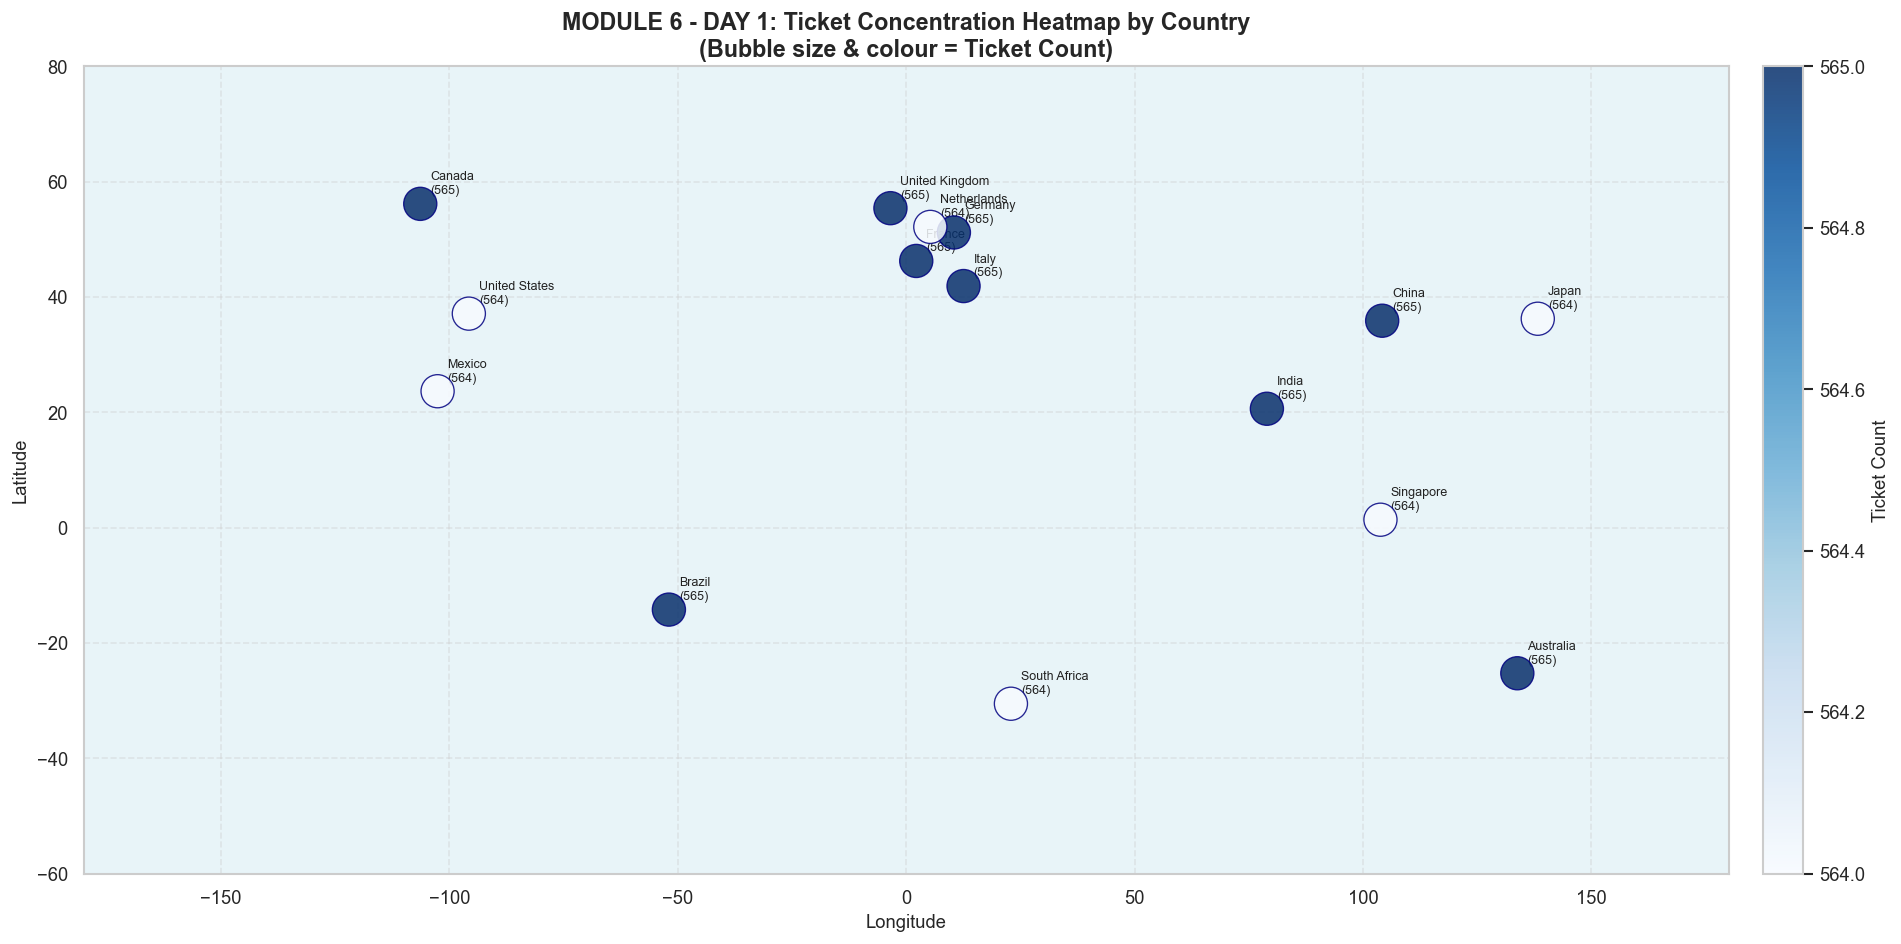

Saved: mod6_day1_geo_heatmap.png


In [15]:
# Heatmap (Bubble Map) — Ticket Concentration by Country
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_facecolor('#e8f4f8')
ax.set_xlim(-180, 180)
ax.set_ylim(-60, 80)
ax.grid(True, linestyle='--', alpha=0.4)

sc = ax.scatter(
    ticket_by_country['Longitude'], ticket_by_country['Latitude'],
    s=ticket_by_country['Ticket_Count'] * 0.7,
    c=ticket_by_country['Ticket_Count'],
    cmap='Blues', edgecolors='navy', linewidths=0.8, alpha=0.85, zorder=5
)
cbar = plt.colorbar(sc, ax=ax, fraction=0.025, pad=0.02)
cbar.set_label('Ticket Count', fontsize=11)

for _, row in ticket_by_country.iterrows():
    ax.annotate(
        f"{row['Country']}\n({row['Ticket_Count']})",
        (row['Longitude'], row['Latitude']),
        textcoords='offset points', xytext=(6, 6), fontsize=7.5, color='#222'
    )

ax.set_xlabel('Longitude', fontsize=11)
ax.set_ylabel('Latitude',  fontsize=11)
ax.set_title('MODULE 6 - DAY 1: Ticket Concentration Heatmap by Country\n'
             '(Bubble size & colour = Ticket Count)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('mod6_day1_geo_heatmap.png', bbox_inches='tight')
plt.show()
print('Saved: mod6_day1_geo_heatmap.png')

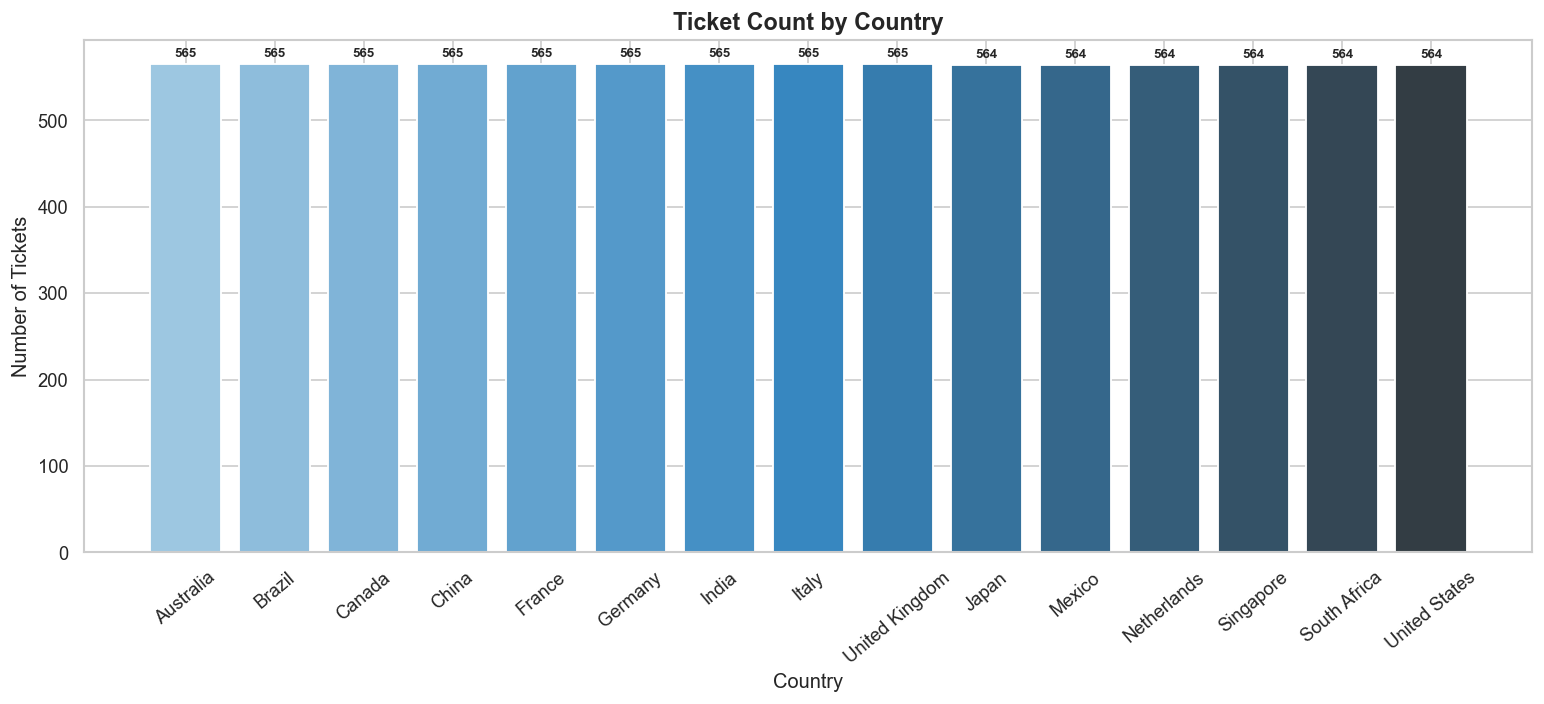

Saved: mod6_day1_ticket_count_by_country.png


In [16]:
# Bar Chart: Ticket Count by Country
fig, ax = plt.subplots(figsize=(13, 6))
pal = sns.color_palette('Blues_d', len(ticket_by_country))
bars = ax.bar(ticket_by_country['Country'], ticket_by_country['Ticket_Count'],
              color=pal, edgecolor='white', linewidth=1.1)
ax.set_title('Ticket Count by Country', fontsize=14, fontweight='bold')
ax.set_xlabel('Country', fontsize=12)
ax.set_ylabel('Number of Tickets', fontsize=12)
ax.tick_params(axis='x', rotation=40)
for bar, v in zip(bars, ticket_by_country['Ticket_Count']):
    ax.text(bar.get_x() + bar.get_width()/2, v + 5, f'{v:,}',
            ha='center', va='bottom', fontsize=8, fontweight='bold')
plt.tight_layout()
plt.savefig('mod6_day1_ticket_count_by_country.png', bbox_inches='tight')
plt.show()
print('Saved: mod6_day1_ticket_count_by_country.png')

In [17]:
# Geographic Insight Summary
top_c    = ticket_by_country.iloc[0]
bottom_c = ticket_by_country.iloc[-1]
print('=' * 60)
print('  GEOGRAPHIC INSIGHT SUMMARY')
print('=' * 60)
print(f'  Highest volume : {top_c["Country"]}  ({top_c["Ticket_Count"]:,} tickets)')
print(f'  Lowest  volume : {bottom_c["Country"]}  ({bottom_c["Ticket_Count"]:,} tickets)')
print(f'  Countries in scope: {len(ticket_by_country)}')
print('\n  Operational Implication:')
print(f'  -> {top_c["Country"]} may need more agents or automation.')
print(f'  -> Lower-volume regions can use shared or async support.')

  GEOGRAPHIC INSIGHT SUMMARY
  Highest volume : Australia  (565 tickets)
  Lowest  volume : United States  (564 tickets)
  Countries in scope: 15

  Operational Implication:
  -> Australia may need more agents or automation.
  -> Lower-volume regions can use shared or async support.


## DAY 2: Category-Level Geographic Analysis

In [18]:
cat_geo = (
    df.groupby(['Country','Ticket_Subject','Latitude','Longitude'])
      .size().reset_index(name='Ticket_Count')
)
print('Category x Country rows:', len(cat_geo))
print(cat_geo.head(8).to_string(index=False))

Category x Country rows: 240
  Country       Ticket_Subject   Latitude  Longitude  Ticket_Count
Australia       Account Access -25.274398 133.775136            38
Australia         Battery Life -25.274398 133.775136            38
Australia Cancellation Request -25.274398 133.775136            29
Australia            Data Loss -25.274398 133.775136            26
Australia     Delivery Problem -25.274398 133.775136            40
Australia        Display Issue -25.274398 133.775136            32
Australia       Hardware Issue -25.274398 133.775136            35
Australia Installation Support -25.274398 133.775136            28


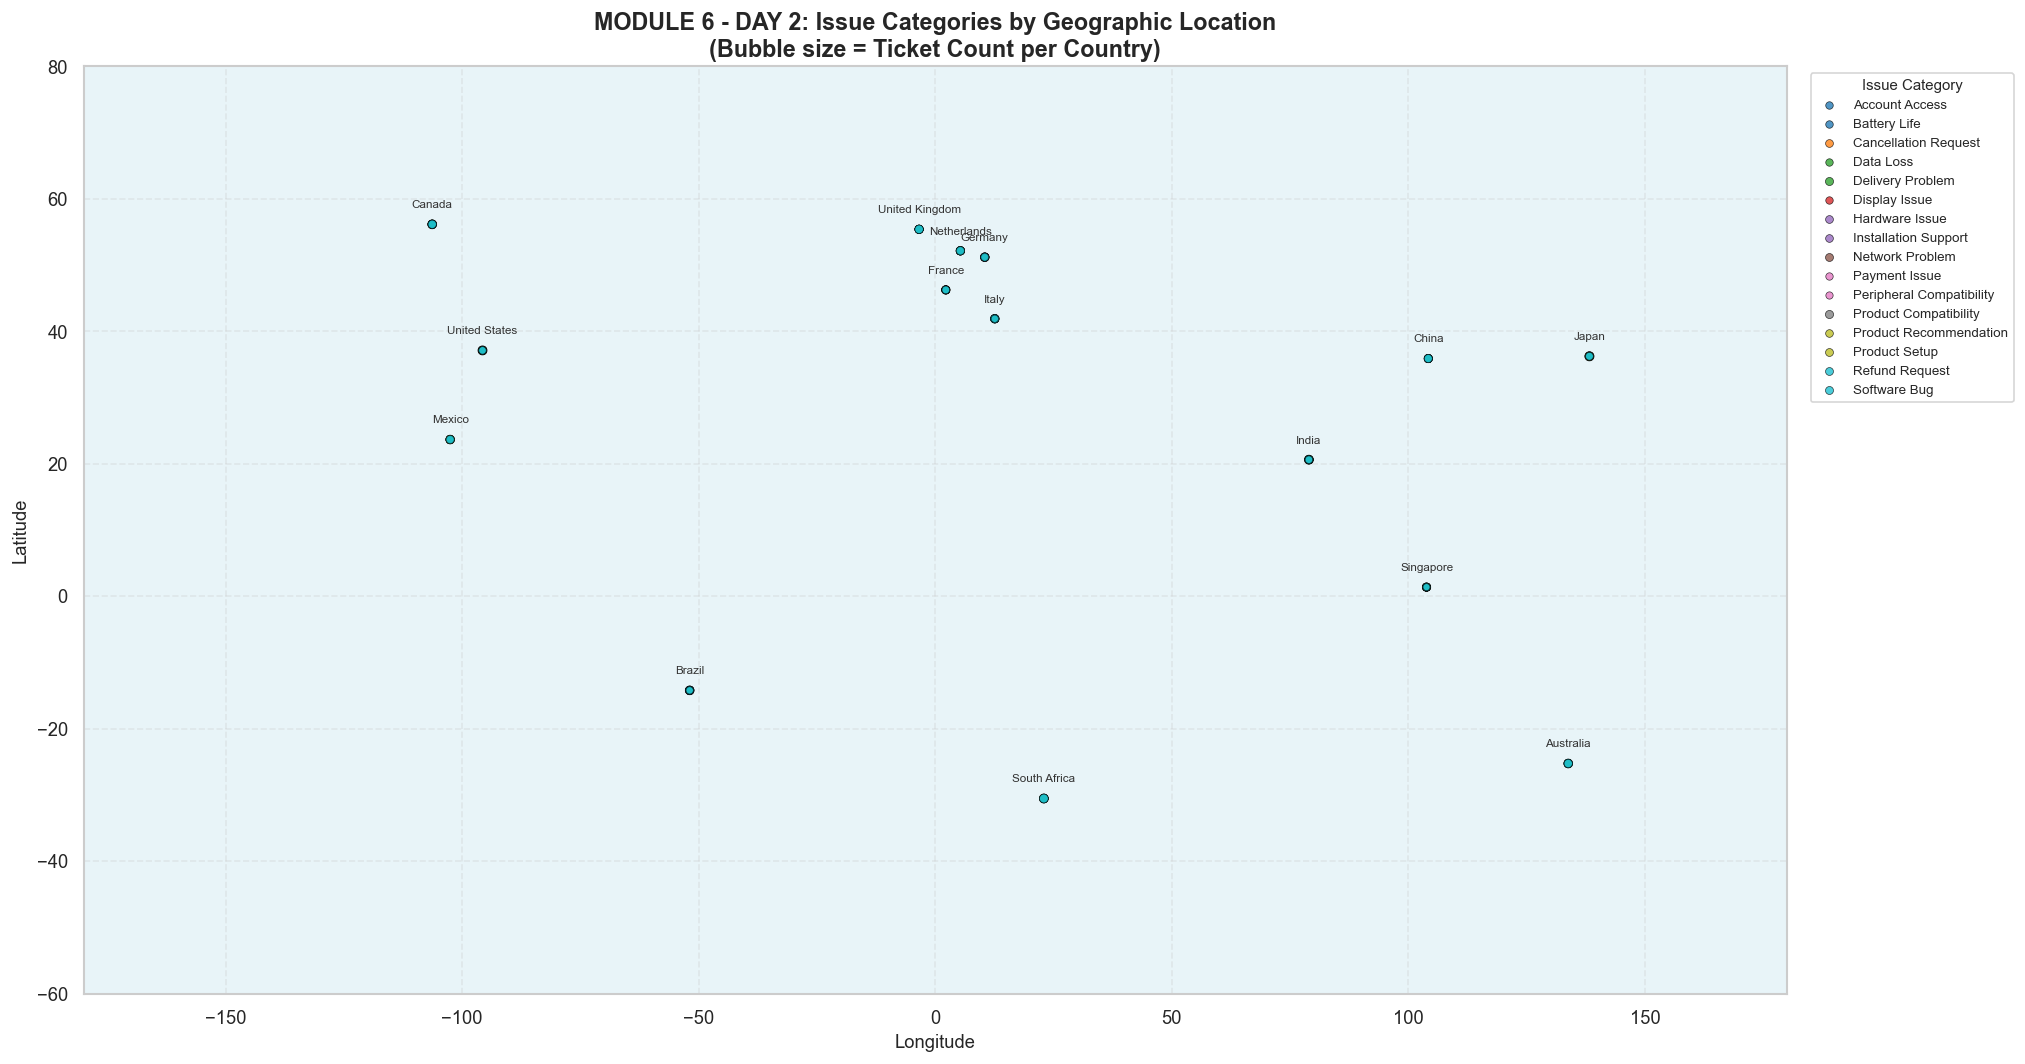

Saved: mod6_day2_category_geo_scatter.png


In [19]:
# Scatter Map: Issue Categories by Geographic Location
subjects   = sorted(cat_geo['Ticket_Subject'].unique())
cmap_cat   = plt.cm.get_cmap('tab10', len(subjects))
subject_clr = {s: cmap_cat(i) for i, s in enumerate(subjects)}

fig, ax = plt.subplots(figsize=(17, 9))
ax.set_facecolor('#e8f4f8')
ax.set_xlim(-180, 180)
ax.set_ylim(-60, 80)
ax.grid(True, linestyle='--', alpha=0.35)

for subj, grp in cat_geo.groupby('Ticket_Subject'):
    ax.scatter(
        grp['Longitude'], grp['Latitude'],
        s=grp['Ticket_Count'] * 0.6,
        color=subject_clr[subj], edgecolors='black',
        linewidths=0.4, alpha=0.78, label=subj, zorder=4
    )

for _, row in ticket_by_country.iterrows():
    ax.text(row['Longitude'], row['Latitude'] + 2.5,
            row['Country'], ha='center', fontsize=7, color='#333', zorder=5)

ax.legend(title='Issue Category', bbox_to_anchor=(1.01, 1),
          loc='upper left', fontsize=8, title_fontsize=9)
ax.set_xlabel('Longitude', fontsize=11)
ax.set_ylabel('Latitude',  fontsize=11)
ax.set_title('MODULE 6 - DAY 2: Issue Categories by Geographic Location\n'
             '(Bubble size = Ticket Count per Country)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('mod6_day2_category_geo_scatter.png', bbox_inches='tight')
plt.show()
print('Saved: mod6_day2_category_geo_scatter.png')

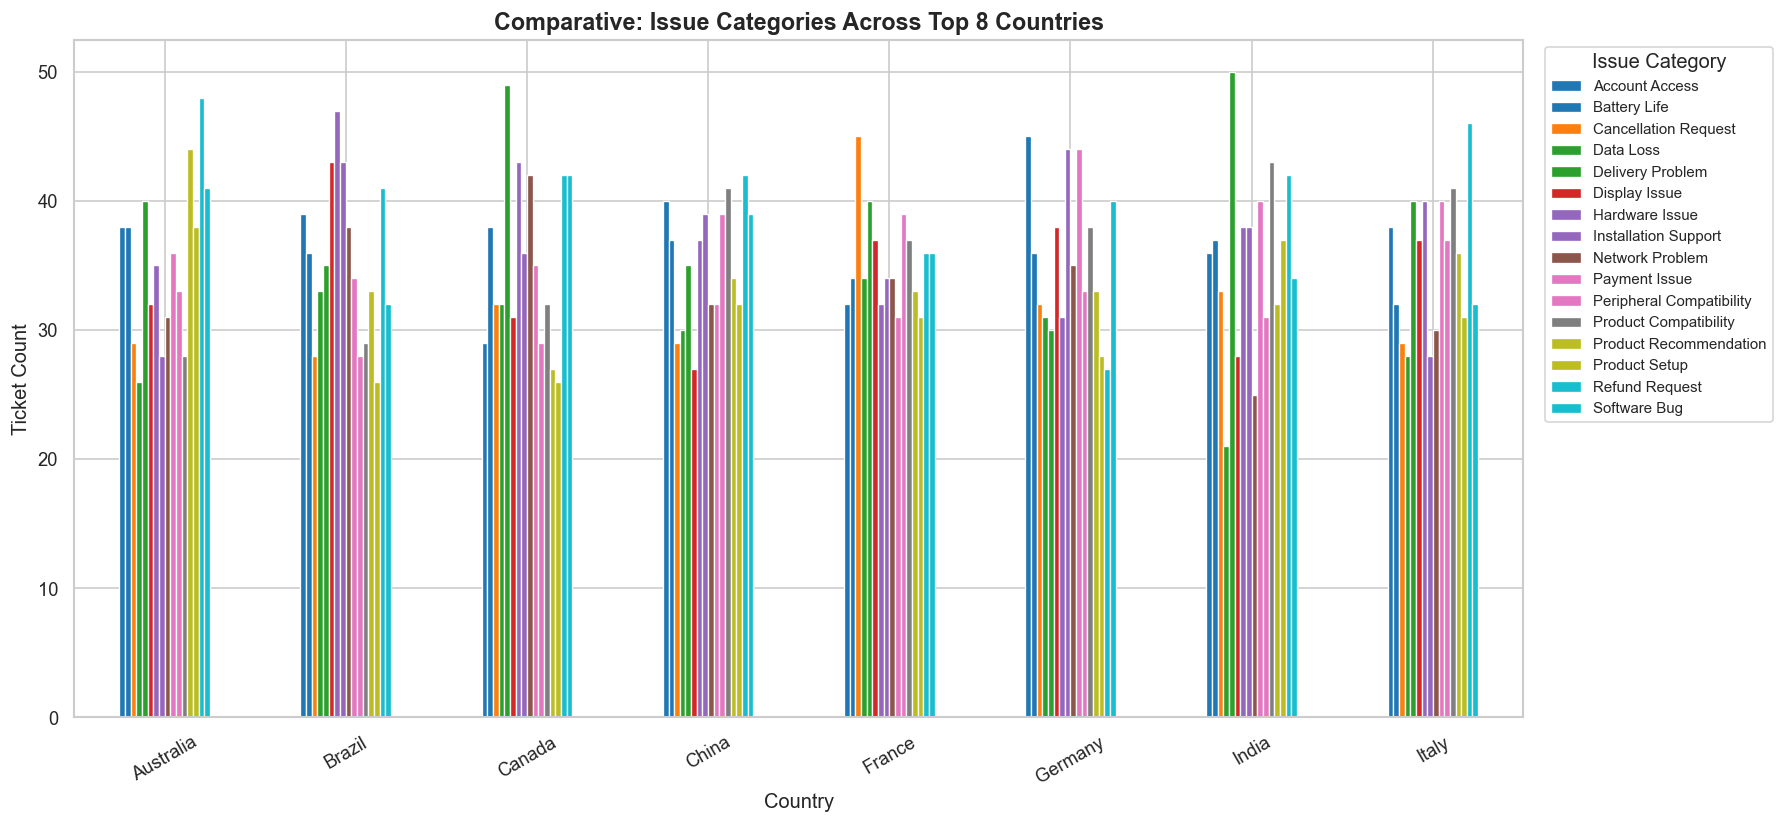

Saved: mod6_day2_category_country_comparison.png


In [20]:
# Grouped Bar: Issue Categories across Top 8 Countries
top8 = ticket_by_country.head(8)['Country'].tolist()
pivot_cat = (
    cat_geo[cat_geo['Country'].isin(top8)]
    .pivot_table(index='Country', columns='Ticket_Subject',
                 values='Ticket_Count', fill_value=0)
)

fig, ax = plt.subplots(figsize=(15, 7))
pivot_cat.plot(kind='bar', ax=ax, colormap='tab10', edgecolor='white', linewidth=0.8)
ax.set_title('Comparative: Issue Categories Across Top 8 Countries',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Country', fontsize=12)
ax.set_ylabel('Ticket Count', fontsize=12)
ax.tick_params(axis='x', rotation=30)
ax.legend(title='Issue Category', bbox_to_anchor=(1.01, 1),
          loc='upper left', fontsize=9)
plt.tight_layout()
plt.savefig('mod6_day2_category_country_comparison.png', bbox_inches='tight')
plt.show()
print('Saved: mod6_day2_category_country_comparison.png')

In [21]:
# Dominant issue per country
dominant = (
    cat_geo.sort_values('Ticket_Count', ascending=False)
           .groupby('Country').first().reset_index()
           [['Country','Ticket_Subject','Ticket_Count']]
           .rename(columns={'Ticket_Subject':'Dominant_Issue','Ticket_Count':'Count'})
)
print('Dominant Issue Category per Country:')
print(dominant.to_string(index=False))

Dominant Issue Category per Country:
       Country        Dominant_Issue  Count
     Australia        Refund Request     48
        Brazil        Hardware Issue     47
        Canada      Delivery Problem     49
         China        Refund Request     42
        France  Cancellation Request     45
       Germany        Account Access     45
         India      Delivery Problem     50
         Italy        Refund Request     46
         Japan Product Compatibility     52
        Mexico         Product Setup     47
   Netherlands       Network Problem     44
     Singapore             Data Loss     43
  South Africa         Product Setup     49
United Kingdom          Software Bug     44
 United States       Network Problem     51


## DAY 3: Geographic Performance Comparison

In [22]:
perf_by_country = (
    df.groupby(['Country','Latitude','Longitude'])['Resolution_Time_hrs']
      .agg(Avg_Resolution_Time='mean', Ticket_Count='count')
      .reset_index()
      .dropna(subset=['Avg_Resolution_Time'])
      .sort_values('Avg_Resolution_Time', ascending=False)
)
print('Performance by Country:')
print(perf_by_country[['Country','Avg_Resolution_Time','Ticket_Count']].to_string(index=False))

Performance by Country:
       Country  Avg_Resolution_Time  Ticket_Count
     Australia             8.137195            82
 United States             8.114141            99
   Netherlands             8.016667            99
     Singapore             7.908805           106
        Canada             7.899145            78
         China             7.847619            91
         Italy             7.762411            94
         India             7.643023            86
        France             7.589869           102
        Brazil             7.505696            79
        Mexico             7.475627            93
       Germany             7.335965           114
United Kingdom             7.098535            91
  South Africa             6.905056            89
         Japan             6.671549            99


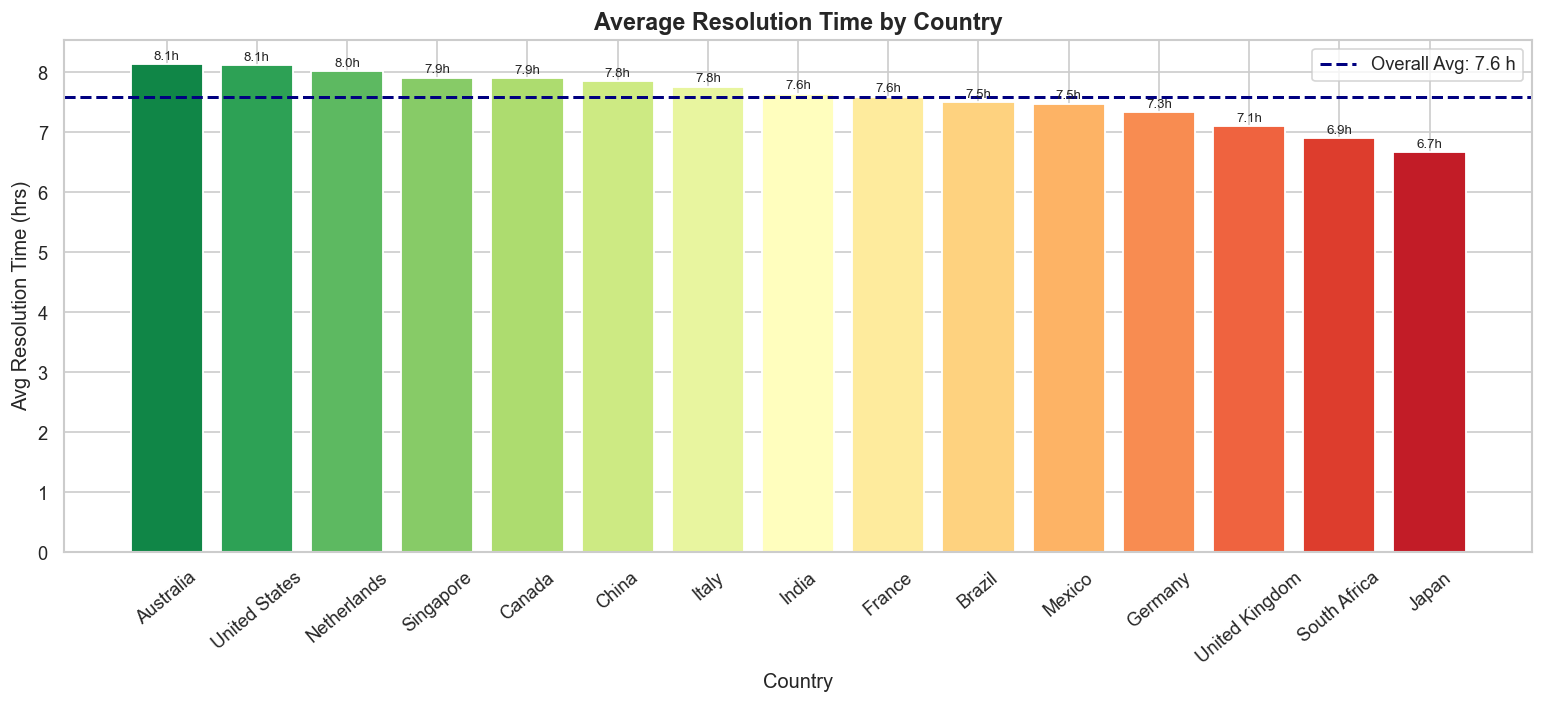

Saved: mod6_day3_resolution_by_country.png


In [23]:
# Bar Chart: Country vs Avg Resolution Time
fig, ax = plt.subplots(figsize=(13, 6))
palette_g = sns.color_palette('RdYlGn_r', len(perf_by_country))
bars = ax.bar(perf_by_country['Country'], perf_by_country['Avg_Resolution_Time'],
              color=palette_g, edgecolor='white', linewidth=1.1)
overall_mean = perf_by_country['Avg_Resolution_Time'].mean()
ax.axhline(overall_mean, color='navy', linestyle='--', linewidth=1.8,
           label=f'Overall Avg: {overall_mean:.1f} h')
ax.set_title('Average Resolution Time by Country', fontsize=14, fontweight='bold')
ax.set_xlabel('Country', fontsize=12)
ax.set_ylabel('Avg Resolution Time (hrs)', fontsize=12)
ax.tick_params(axis='x', rotation=40)
ax.legend(fontsize=11)
for bar, v in zip(bars, perf_by_country['Avg_Resolution_Time']):
    ax.text(bar.get_x() + bar.get_width()/2, v + 0.03,
            f'{v:.1f}h', ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.savefig('mod6_day3_resolution_by_country.png', bbox_inches='tight')
plt.show()
print('Saved: mod6_day3_resolution_by_country.png')

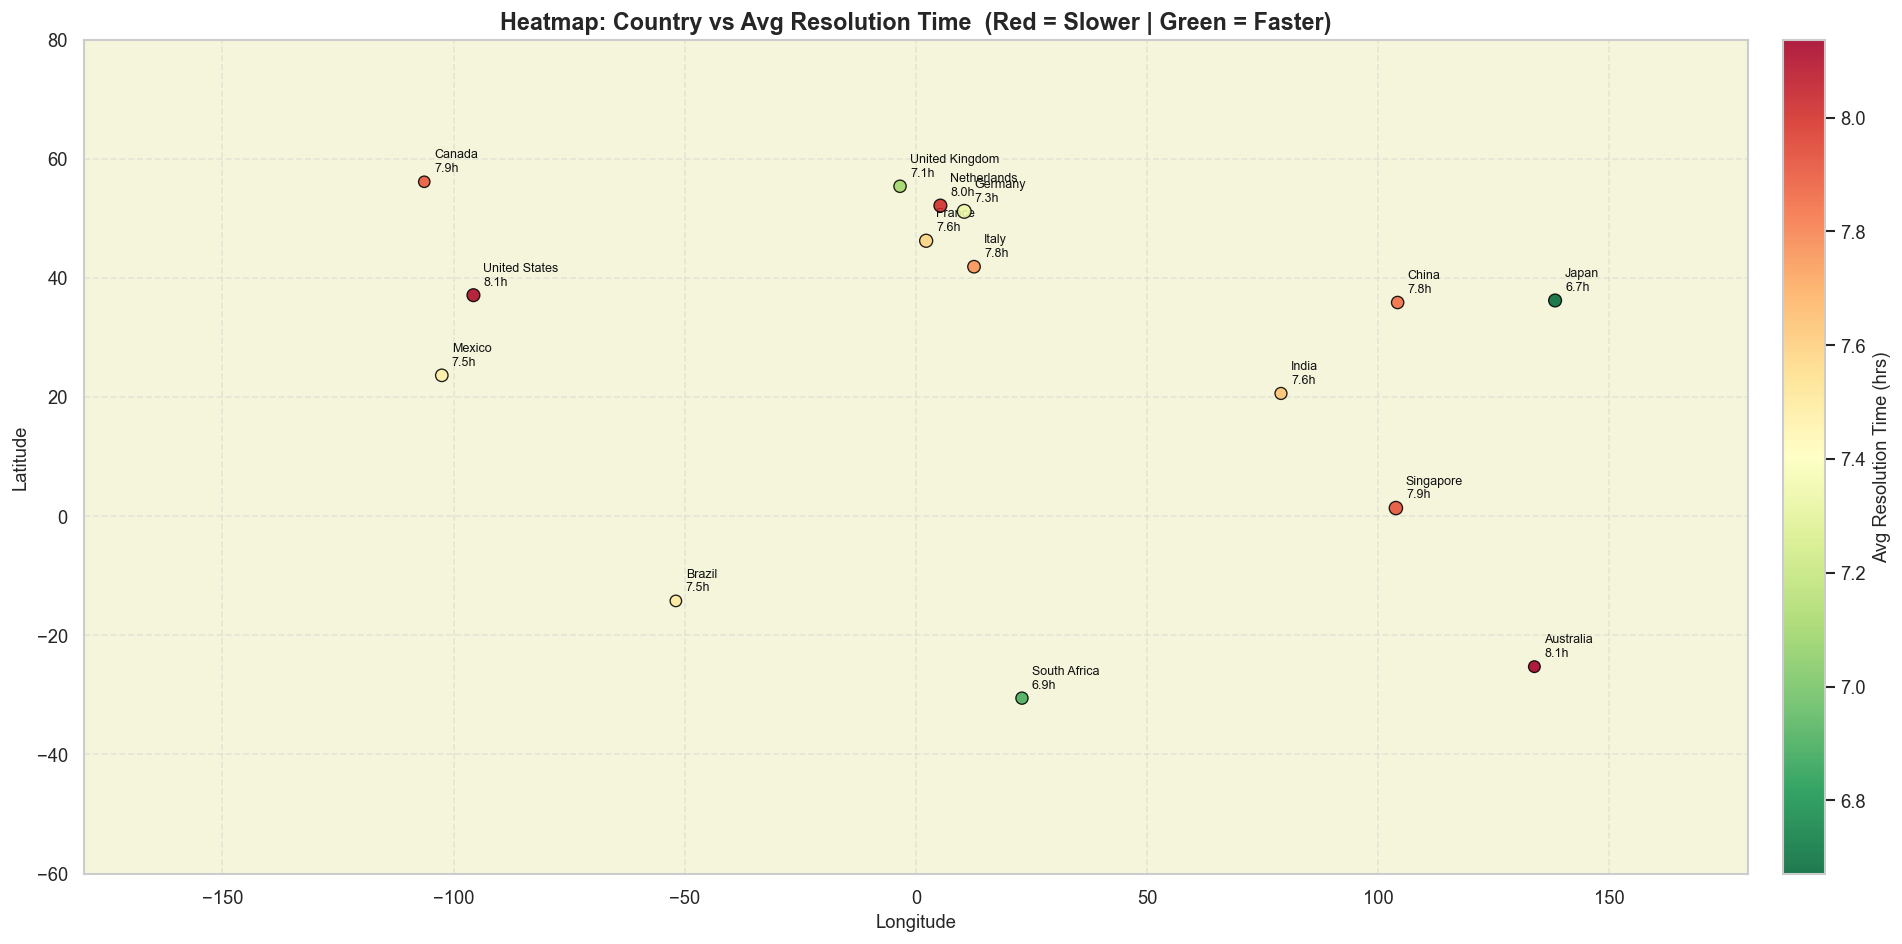

Saved: mod6_day3_resolution_heatmap.png


In [24]:
# Bubble Heatmap: Country vs Avg Resolution Time (geographic)
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_facecolor('#f5f5dc')
ax.set_xlim(-180, 180)
ax.set_ylim(-60, 80)
ax.grid(True, linestyle='--', alpha=0.4)

sc = ax.scatter(
    perf_by_country['Longitude'], perf_by_country['Latitude'],
    s=perf_by_country['Ticket_Count'] * 0.6,
    c=perf_by_country['Avg_Resolution_Time'],
    cmap='RdYlGn_r', edgecolors='black', linewidths=0.8, alpha=0.88, zorder=5
)
cbar = plt.colorbar(sc, ax=ax, fraction=0.025, pad=0.02)
cbar.set_label('Avg Resolution Time (hrs)', fontsize=11)

for _, row in perf_by_country.iterrows():
    ax.annotate(
        f"{row['Country']}\n{row['Avg_Resolution_Time']:.1f}h",
        (row['Longitude'], row['Latitude']),
        textcoords='offset points', xytext=(6, 6), fontsize=7.5, color='#111'
    )

ax.set_xlabel('Longitude', fontsize=11)
ax.set_ylabel('Latitude',  fontsize=11)
ax.set_title('Heatmap: Country vs Avg Resolution Time  (Red = Slower | Green = Faster)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('mod6_day3_resolution_heatmap.png', bbox_inches='tight')
plt.show()
print('Saved: mod6_day3_resolution_heatmap.png')

In [25]:
# Fastest / Slowest + Bottleneck regions
slowest = perf_by_country.iloc[0]
fastest = perf_by_country.iloc[-1]
print(f'Slowest region: {slowest["Country"]}  -  {slowest["Avg_Resolution_Time"]:.2f} hrs')
print(f'Fastest region: {fastest["Country"]}  -  {fastest["Avg_Resolution_Time"]:.2f} hrs')

merged_perf = ticket_by_country.merge(
    perf_by_country[['Country','Avg_Resolution_Time']], on='Country')
merged_perf['High_Volume']     = merged_perf['Ticket_Count'] > merged_perf['Ticket_Count'].median()
merged_perf['Slow_Resolution'] = merged_perf['Avg_Resolution_Time'] > merged_perf['Avg_Resolution_Time'].median()
bottlenecks = merged_perf[merged_perf['High_Volume'] & merged_perf['Slow_Resolution']]
print('\nBottleneck Regions (high volume AND slow resolution):')
print(bottlenecks[['Country','Ticket_Count','Avg_Resolution_Time']].to_string(index=False))

Slowest region: Australia  -  8.14 hrs
Fastest region: Japan  -  6.67 hrs

Bottleneck Regions (high volume AND slow resolution):
Empty DataFrame
Columns: [Country, Ticket_Count, Avg_Resolution_Time]
Index: []


## DAY 4: Cluster Size, Performance Impact & Final Insights

In [26]:
# Cluster = Ticket_Subject (issue category)
cluster_analysis = (
    df.groupby('Ticket_Subject')
      .agg(
          Cluster_Size        = ('Ticket_ID',          'count'),
          Avg_Resolution_Time = ('Resolution_Time_hrs', 'mean'),
          Pct_Unresolved      = ('Is_Resolved',         lambda x: (~x).mean() * 100),
          Pct_High_Priority   = ('Ticket_Priority',
                                 lambda x: x.isin(['high','critical']).mean() * 100)
      )
      .reset_index()
      .rename(columns={'Ticket_Subject': 'Cluster_Name'})
)

max_rt = cluster_analysis['Avg_Resolution_Time'].max()
cluster_analysis['Performance_Score'] = (
    (1 - cluster_analysis['Avg_Resolution_Time'] / max_rt) * 100
).fillna(50).round(2)

print('Cluster Analysis Summary:')
print(cluster_analysis[['Cluster_Name','Cluster_Size','Avg_Resolution_Time',
                          'Pct_Unresolved','Performance_Score']].to_string(index=False))

Cluster Analysis Summary:
            Cluster_Name  Cluster_Size  Avg_Resolution_Time  Pct_Unresolved  Performance_Score
          Account Access           509             7.426165       81.728880              15.73
            Battery Life           542             8.351333       86.162362               5.23
    Cancellation Request           487             7.533130       83.162218              14.51
               Data Loss           491             7.625000       86.150713              13.47
        Delivery Problem           561             6.931276       85.561497              21.34
           Display Issue           478             7.706164       84.728033              12.55
          Hardware Issue           547             7.926667       82.632541              10.05
    Installation Support           530             6.866275       83.962264              22.08
         Network Problem           539             7.863208       80.333952              10.77
           Payment Issue

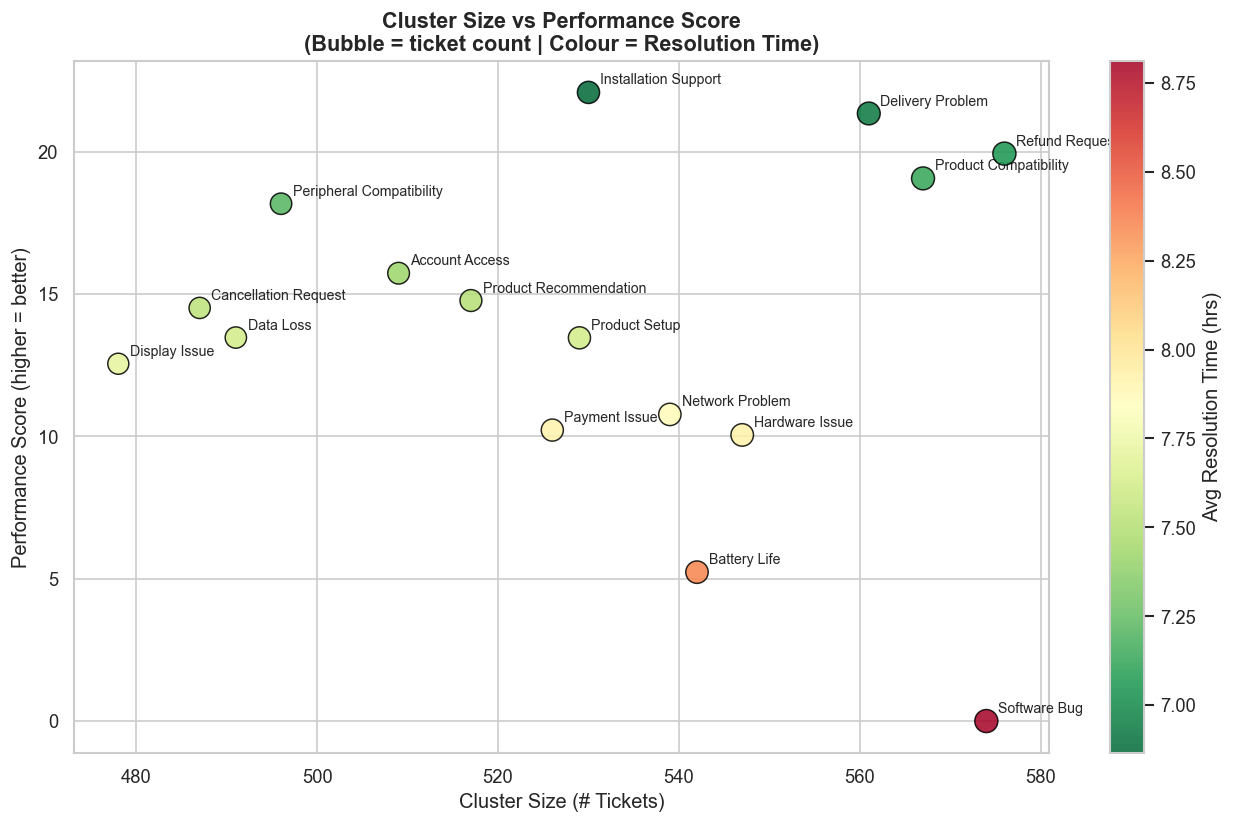

Saved: mod6_day4_cluster_scatter.png


In [27]:
# Scatter Plot: Cluster Size vs Performance Score
fig, ax = plt.subplots(figsize=(11, 7))
sc = ax.scatter(
    cluster_analysis['Cluster_Size'],
    cluster_analysis['Performance_Score'],
    c=cluster_analysis['Avg_Resolution_Time'],
    cmap='RdYlGn_r',
    s=cluster_analysis['Cluster_Size'] / 3.0,
    edgecolors='black', linewidths=0.9, alpha=0.85, zorder=4
)
plt.colorbar(sc, ax=ax, label='Avg Resolution Time (hrs)')

for _, row in cluster_analysis.iterrows():
    ax.annotate(
        row['Cluster_Name'],
        (row['Cluster_Size'], row['Performance_Score']),
        textcoords='offset points', xytext=(7, 5), fontsize=8.5
    )

ax.set_title('Cluster Size vs Performance Score\n'
             '(Bubble = ticket count | Colour = Resolution Time)',
             fontsize=13, fontweight='bold')
ax.set_xlabel('Cluster Size (# Tickets)', fontsize=12)
ax.set_ylabel('Performance Score (higher = better)', fontsize=12)
plt.tight_layout()
plt.savefig('mod6_day4_cluster_scatter.png', bbox_inches='tight')
plt.show()
print('Saved: mod6_day4_cluster_scatter.png')

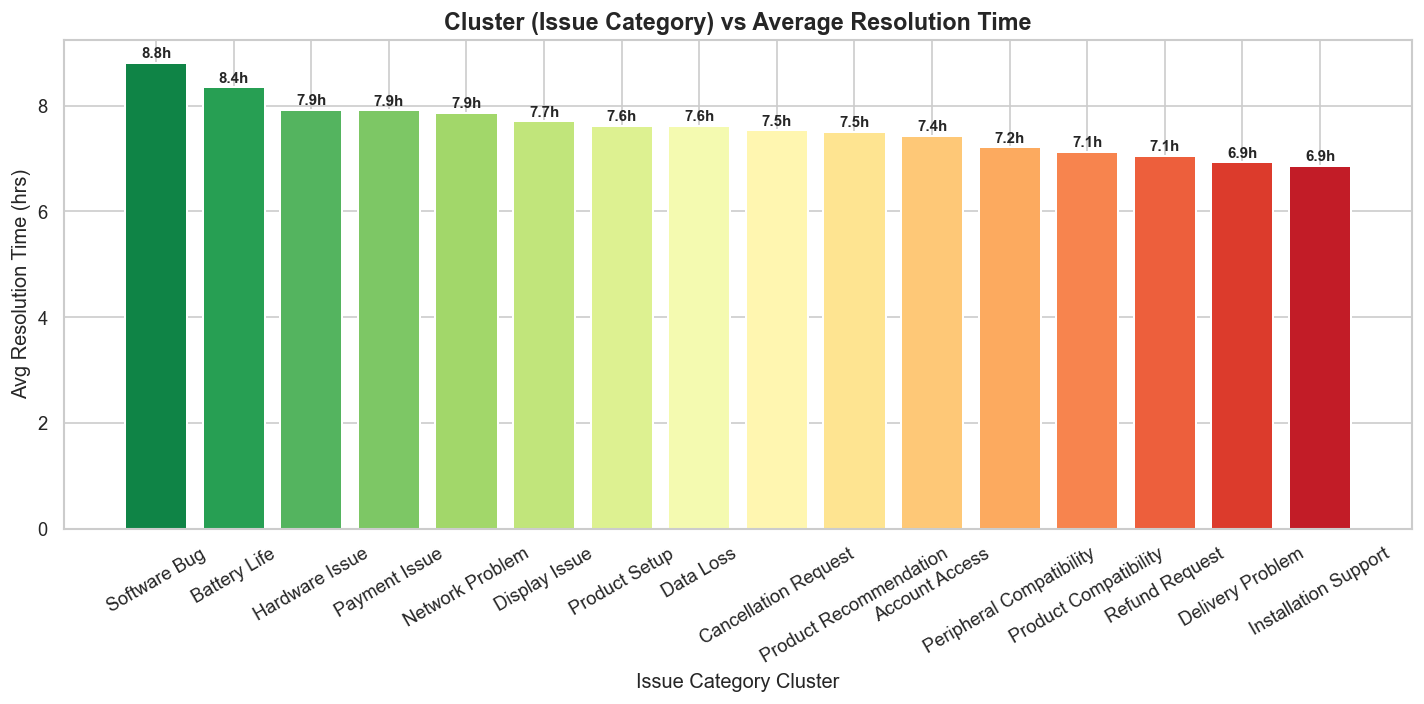

Saved: mod6_day4_cluster_resolution.png


In [28]:
# Bar Chart: Cluster vs Avg Resolution Time
cluster_sorted = cluster_analysis.sort_values('Avg_Resolution_Time', ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
pal_c = sns.color_palette('RdYlGn_r', len(cluster_sorted))
bars = ax.bar(cluster_sorted['Cluster_Name'], cluster_sorted['Avg_Resolution_Time'],
              color=pal_c, edgecolor='white', linewidth=1.2)
ax.set_title('Cluster (Issue Category) vs Average Resolution Time',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Issue Category Cluster', fontsize=12)
ax.set_ylabel('Avg Resolution Time (hrs)', fontsize=12)
ax.tick_params(axis='x', rotation=30)
for bar, v in zip(bars, cluster_sorted['Avg_Resolution_Time']):
    if pd.notna(v):
        ax.text(bar.get_x() + bar.get_width()/2, v + 0.04,
                f'{v:.1f}h', ha='center', va='bottom', fontsize=9, fontweight='bold')
plt.tight_layout()
plt.savefig('mod6_day4_cluster_resolution.png', bbox_inches='tight')
plt.show()
print('Saved: mod6_day4_cluster_resolution.png')

In [29]:
# Final Insights & Recommendations
worst_cluster   = cluster_sorted.iloc[0]
best_cluster    = cluster_sorted.iloc[-1]
high_unresolved = cluster_analysis.sort_values('Pct_Unresolved', ascending=False).iloc[0]
high_hp_cluster = cluster_analysis.sort_values('Pct_High_Priority', ascending=False).iloc[0]

print('=' * 65)
print('  FINAL PERFORMANCE INSIGHTS & RECOMMENDATIONS')
print('  MILESTONE 3 — MODULE 5 & 6')
print('=' * 65)

print('\n[CLUSTER PERFORMANCE]')
print(f'  Slowest cluster      : {worst_cluster["Cluster_Name"]}'
      f' ({worst_cluster["Avg_Resolution_Time"]:.1f} hrs avg)')
print(f'  Fastest cluster      : {best_cluster["Cluster_Name"]}'
      f' ({best_cluster["Avg_Resolution_Time"]:.1f} hrs avg)')
print(f'  Highest unresolved % : {high_unresolved["Cluster_Name"]}'
      f' ({high_unresolved["Pct_Unresolved"]:.1f}%)')
print(f'  Most high-priority % : {high_hp_cluster["Cluster_Name"]}'
      f' ({high_hp_cluster["Pct_High_Priority"]:.1f}%)')

print('\n[GEOGRAPHIC INSIGHTS]')
print(f'  Slowest region : {slowest["Country"]}  ({slowest["Avg_Resolution_Time"]:.1f} hrs)')
print(f'  Fastest region : {fastest["Country"]}  ({fastest["Avg_Resolution_Time"]:.1f} hrs)')
if len(bottlenecks) > 0:
    bn = ', '.join(bottlenecks['Country'].tolist())
    print(f'  Bottleneck regions : {bn}')

print('\n[RECOMMENDATIONS]')
print(f'  1. Add automation/dedicated queue for "{worst_cluster["Cluster_Name"]}" tickets.')
print(f'  2. Audit unresolved backlog in "{high_unresolved["Cluster_Name"]}".')
print(f'  3. Replicate best practices from {fastest["Country"]} to slower regions.')
print(f'  4. Deploy surge support to bottleneck regions during peak periods.')
print(f'  5. Implement SLA alerts for Critical and High-priority tickets globally.')
print('=' * 65)

  FINAL PERFORMANCE INSIGHTS & RECOMMENDATIONS
  MILESTONE 3 — MODULE 5 & 6

[CLUSTER PERFORMANCE]
  Slowest cluster      : Software Bug (8.8 hrs avg)
  Fastest cluster      : Installation Support (6.9 hrs avg)
  Highest unresolved % : Battery Life (86.2%)
  Most high-priority % : Data Loss (52.1%)

[GEOGRAPHIC INSIGHTS]
  Slowest region : Australia  (8.1 hrs)
  Fastest region : Japan  (6.7 hrs)

[RECOMMENDATIONS]
  1. Add automation/dedicated queue for "Software Bug" tickets.
  2. Audit unresolved backlog in "Battery Life".
  3. Replicate best practices from Japan to slower regions.
  4. Deploy surge support to bottleneck regions during peak periods.
  5. Implement SLA alerts for Critical and High-priority tickets globally.
